## GDE Mapping Data Analysis and Visualization

This Python script utilizes Google Earth Engine, pandas, and Plotly to analyze and visualize vegetation indices and Actual Evapotranspiration (AET) data over time for a specified geographical location. Additionally, it incorporates data normalization using the Min-Max Scaler from scikit-learn.

### Initialization and Data Input
- **Libraries**: Imports `ee` for Google Earth Engine, `pandas` for data manipulation, `pyperclip` for clipboard interactions, `plotly.graph_objects` for visualization, and `MinMaxScaler` from scikit-learn for data scaling.
- **Earth Engine Initialization**: Initializes the Google Earth Engine API for data retrieval.
- **Coordinate Retrieval**: Extracts geographical coordinates from the clipboard, which are used to define the location of interest.

### Data Preparation
- **Geographical Point Definition**: Creates a geographical point using the extracted latitude and longitude.
- **Time Range Definition**: Sets the time range for the analysis from February 2000 to February 2022.
- **Dataset Loading**: Loads the Landsat 7 image collection and TERN AET dataset, filtering both by the specified time range and geographical bounds.

### Data Processing
- **Index Calculation**: Defines a function `add_indices` to calculate Normalized Difference Vegetation Index (NDVI), Water Index (NDWI), and Enhanced Vegetation Index (EVI) for each Landsat 7 image.
- **Data Extraction**: Implements functions to extract the calculated indices and AET values from the images, converting them into a format suitable for aggregation.

### Data Aggregation and Transformation
- **Conversion to DataFrame**: Transforms the extracted data into pandas DataFrames for easier manipulation.
- **Monthly Aggregation**: Aggregates data by month to compute average values of NDVI, NDWI, EVI, and AET, ensuring coverage for all months in the range using period ranges and reindexing.
- **Missing Data Handling**: Interpolates missing data points to maintain continuity in the time series.

### Data Normalization
- **MinMax Scaling**: Applies Min-Max scaling to normalize the aggregated monthly data, facilitating comparative visualization across different indices and AET.

### Visualization
- **Plot Configuration**: Uses Plotly to create a scatter plot displaying the normalized monthly averages for NDVI, NDWI, EVI, and AET.
- **Layout Customization**: Configures the plot with appropriate titles, axis labels, and a unified hover mode in a dark theme.
- **Plot Display**: Displays the interactive plot inline within the Jupyter Notebook.

This script is an effective tool for environmental scientists and researchers looking to monitor vegetation health and water usage dynamically over extended periods.


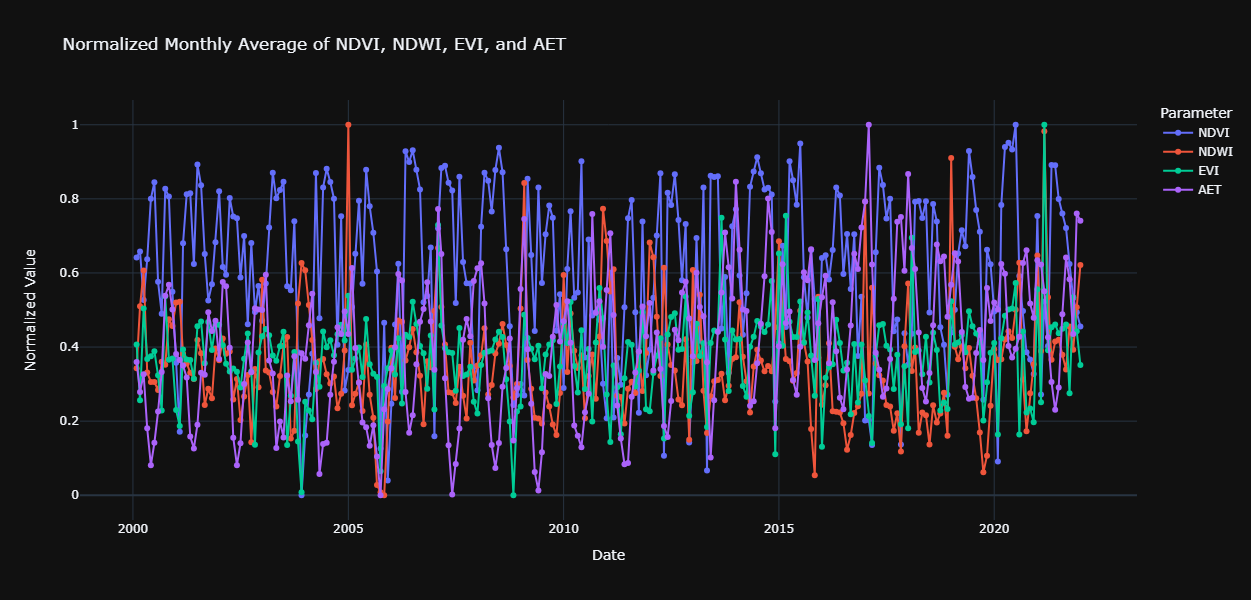

In [112]:
import ee
import pandas as pd
import pyperclip
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Initialize Earth Engine
ee.Initialize()

clipboard_content = pyperclip.paste()  # Example clipboard content for dynamic inputs
latitude_str, longitude_str = clipboard_content.strip().split(',')
latitude = float(latitude_str.strip())
longitude = float(longitude_str.strip())
point = ee.Geometry.Point([longitude, latitude])

# Define the time range for analysis
start_date = '2000-02-01'
end_date = '2022-02-01'

# Load the Landsat 7 image collection and TERN AET dataset with applied filters
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate(start_date, end_date).filterBounds(point)
aet_dataset = ee.ImageCollection('TERN/AET/CMRSET_LANDSAT_V2_2').filterDate(start_date, end_date).filterBounds(point)

def add_indices(image):
    """Function to calculate NDVI, NDWI, and EVI for Landsat 7 images."""
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
    ndwi = image.normalizedDifference(['B4', 'B5']).rename('NDWI')
    evi = image.expression('2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)', {'NIR': image.select('B4'), 'RED': image.select('B3'), 'BLUE': image.select('B1')}).rename('EVI')
    return image.addBands([ndvi, ndwi, evi])

def extract_values(image):
    """Extract index values from each Landsat image."""
    values = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=30)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'NDVI': values.get('NDVI'), 'NDWI': values.get('NDWI'), 'EVI': values.get('EVI')})

def extract_aet(image):
    """Extract AET values from each image in the TERN AET dataset."""
    aet_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=30).get('ETa')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'AET': aet_value})

# Process indices and AET
processed_l7 = l7.map(add_indices)
feature_collection = processed_l7.map(extract_values)
aet_collection = aet_dataset.map(extract_aet)

# Convert to pandas DataFrame
index_df = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])
aet_df = pd.DataFrame([feat['properties'] for feat in aet_collection.getInfo()['features']])
index_df['date'] = pd.to_datetime(index_df['date'])
aet_df['date'] = pd.to_datetime(aet_df['date'])

# Ensure full month coverage
all_months = pd.period_range(start=index_df['date'].min(), end=aet_df['date'].max(), freq='M')
index_df['year_month'] = index_df['date'].dt.to_period('M')
aet_df['year_month'] = aet_df['date'].dt.to_period('M')

# Monthly aggregation and sorting
monthly_indices = index_df.groupby('year_month').agg({'NDVI': 'mean', 'NDWI': 'mean', 'EVI': 'mean'}).reindex(all_months)
monthly_aet = aet_df.groupby('year_month').agg({'AET': 'mean'}).reindex(all_months)

# Handle missing data by interpolation
monthly_indices.interpolate(inplace=True)
monthly_aet.interpolate(inplace=True)

# Combine data and convert dates for plotting
combined_df = pd.concat([monthly_indices, monthly_aet], axis=1)
combined_df.index = combined_df.index.to_timestamp()

# Apply Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)
scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns, index=combined_df.index)

# Plotting
fig = go.Figure()
for column in scaled_df.columns:
    fig.add_trace(go.Scatter(x=scaled_df.index, y=scaled_df[column], mode='lines+markers', name=column))
fig.update_layout(
    title='Normalized Monthly Average of NDVI, NDWI, EVI, and AET',
    xaxis_title='Date',
    yaxis_title='Normalized Value',
    legend_title='Parameter',
    template='plotly_dark',
    hovermode='x unified',
    width=1200,
    height=600
)
fig.show()


In [113]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2000-02-01 to 2022-01-01
Freq: MS
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    264 non-null    float64
 1   NDWI    264 non-null    float64
 2   EVI     264 non-null    float64
 3   AET     264 non-null    float64
dtypes: float64(4)
memory usage: 10.3 KB


## Correlation Analysis of Environmental Indices and AET

This section of the script focuses on analyzing the relationships between different environmental indices (NDVI, NDWI, EVI) and Actual Evapotranspiration (AET) using a correlation matrix and visualizing these relationships with a heatmap.

### Import Plotly Express
- **Library**: The script imports `plotly.express` as `px` which is used for creating data visualizations easily.

### Calculate the Correlation Matrix
- **Correlation Matrix Computation**: Calculates the correlation matrix from the normalized DataFrame `scaled_df`. This matrix quantifies the linear relationships between the indices and AET.
  
### Heatmap Visualization
- **Heatmap Creation**: Utilizes Plotly Express's `imshow` function to create a heatmap of the correlation matrix.




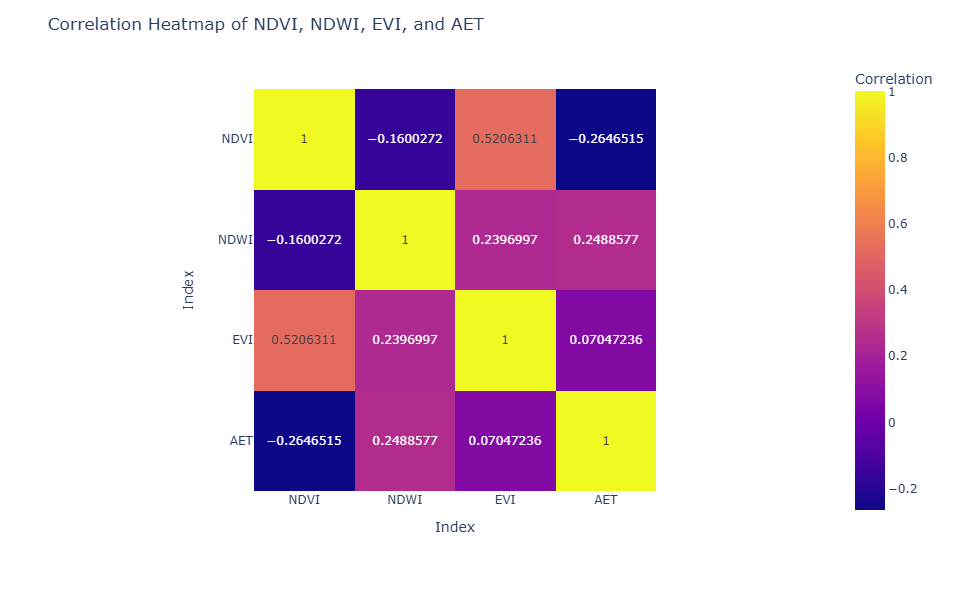

In [114]:
import plotly.express as px

# Assuming 'combined_df' is your DataFrame from previous processing steps

# Calculate the correlation matrix
corr_matrix = scaled_df.corr()

# Create a heatmap
fig_heatmap = px.imshow(corr_matrix, text_auto=True,
                        labels=dict(x="Index", y="Index", color="Correlation"),
                        x=corr_matrix.columns,
                        y=corr_matrix.columns)
fig_heatmap.update_layout(title="Correlation Heatmap of NDVI, NDWI, EVI, and AET",
                          width=600, height=600)
fig_heatmap.show()

## Scatterplot Matrix Visualization

This part of the script creates a scatterplot matrix to visualize pairwise relationships and distributions among multiple environmental indices (NDVI, NDWI, EVI) and Actual Evapotranspiration (AET). This type of visualization is particularly useful for exploring potential correlations and patterns visually.

### Import Plotly Express
- **Library**: Imports `plotly.express` as `px`, which is designed for creating concise, declarative data visualizations.

### Create Scatterplot Matrix
- **Matrix Setup**: Uses the `px.scatter_matrix` function to generate a scatterplot matrix for the specified dimensions (NDVI, NDWI, EVI, and AET) from the `combined_df` DataFrame.

### Utility
The scatterplot matrix provides a comprehensive view of how each index compares against the others, highlighting both distribution trends and potential linear or non-linear relationships. This visualization is invaluable for preliminary data analysis and identifying areas that may warrant further statistical examination or modeling.


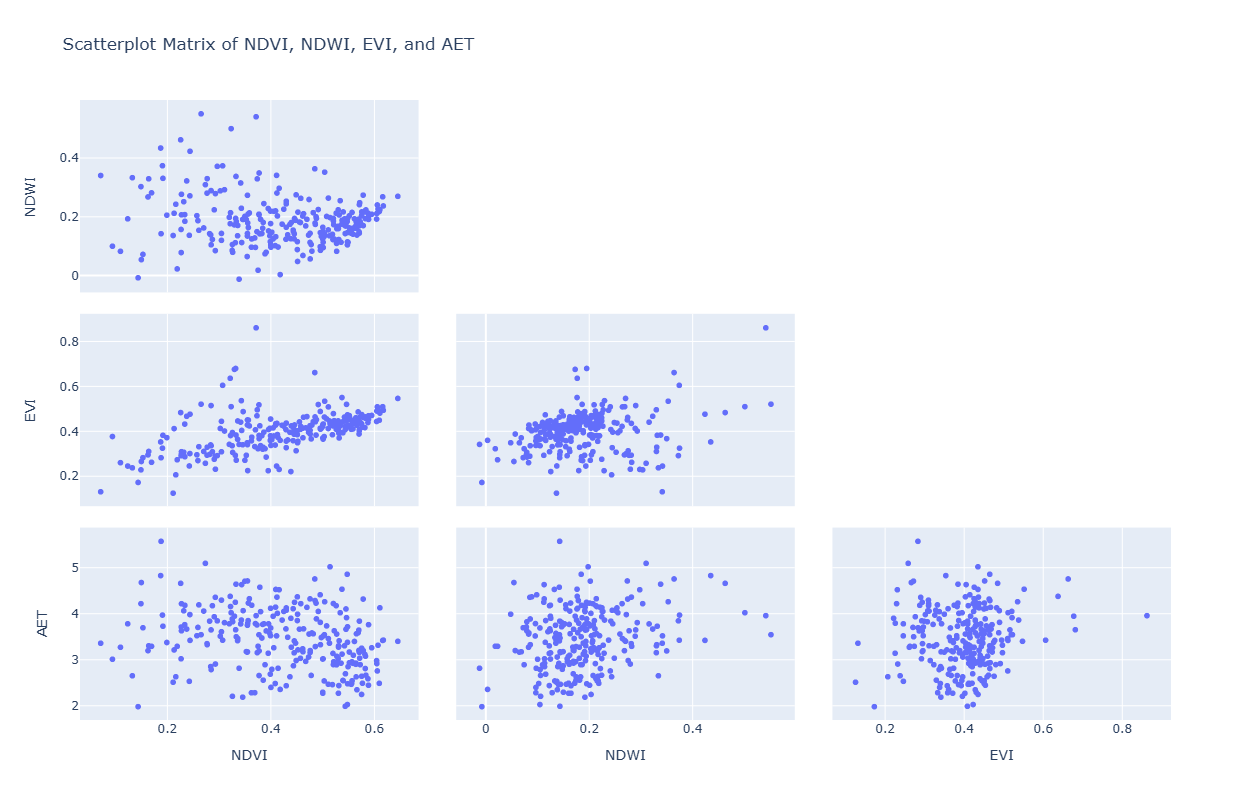

In [115]:
# Create a scatterplot matrix
fig_scatter_matrix = px.scatter_matrix(combined_df,
                                       dimensions=['NDVI', 'NDWI', 'EVI', 'AET'],
                                       labels={col: col for col in scaled_df.columns},
                                       title="Scatterplot Matrix of NDVI, NDWI, EVI, and AET")
fig_scatter_matrix.update_traces(diagonal_visible=False, showupperhalf=False)  # Remove duplicates
fig_scatter_matrix.update_layout(width=800, height=800)
fig_scatter_matrix.show()


## Linear Regression Analysis of Environmental Data

This section of the script demonstrates how to apply linear regression to environmental indices and Actual Evapotranspiration (AET) data over time. It uses NumPy, StatsModels, and Matplotlib for calculations and visualizations.

### Import Required Libraries
- **NumPy**: Used for numerical operations.
- **StatsModels**: Provides classes and functions for the estimation of many different statistical models.
- **Matplotlib**: Used for creating static, interactive, and animated visualizations in Python.

### Function to Plot Linear Regression
- **Function Definition**: `plot_linear_regression` takes a DataFrame and a column name as inputs. It performs linear regression on the specified column against time (treated as a numerical variable) and plots both the actual data points and the fitted trend line.
- **Regression Setup**:
  - **Independent Variable**: Time, converted to a numerical format using `np.arange` to represent sequential time points.
  - **Add Constant**: A constant term is added to the model to accommodate the intercept.
  - **Dependent Variable**: The specified column from the DataFrame.
- **Model Fitting**: Fits a linear regression model using `OLS` (Ordinary Least Squares) from StatsModels.
- **Prediction**: Computes predictions from the fitted model.
- **Display and Summary**: Plots are displayed inline, and the summary of the regression model is printed, providing detailed statistical insights.

### Application of Function
- **Loop Through Columns**: Applies the `plot_linear_regression` function to each column in the `scaled_df` DataFrame, which includes normalized values of NDVI, NDWI, EVI, and AET.

### Utility
This analysis is crucial for understanding trends over time within the dataset, which can help in identifying rising or falling trends in environmental indices and AET. The regression summaries provide statistical metrics such as coefficients, R-squared values, and p-values, which are essential for assessing the validity and strength of the observed trends.


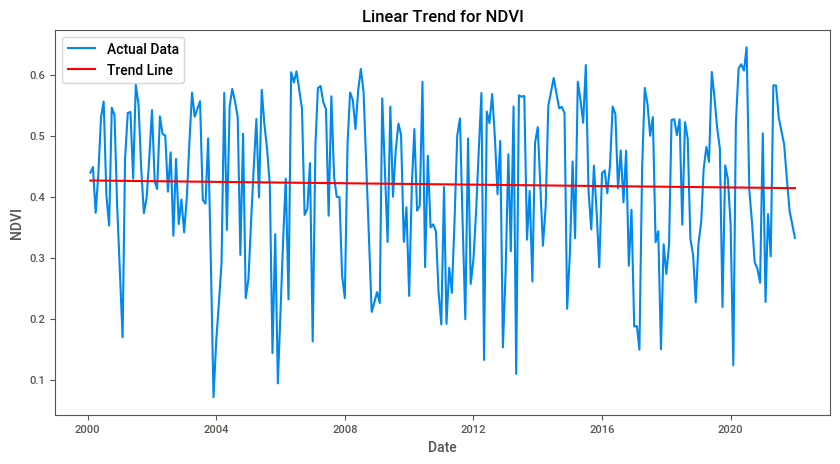

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2127
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.645
Time:                        13:11:01   Log-Likelihood:                 168.87
No. Observations:                 264   AIC:                            -333.7
Df Residuals:                     262   BIC:                            -326.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4267      0.016     27.134      0.0

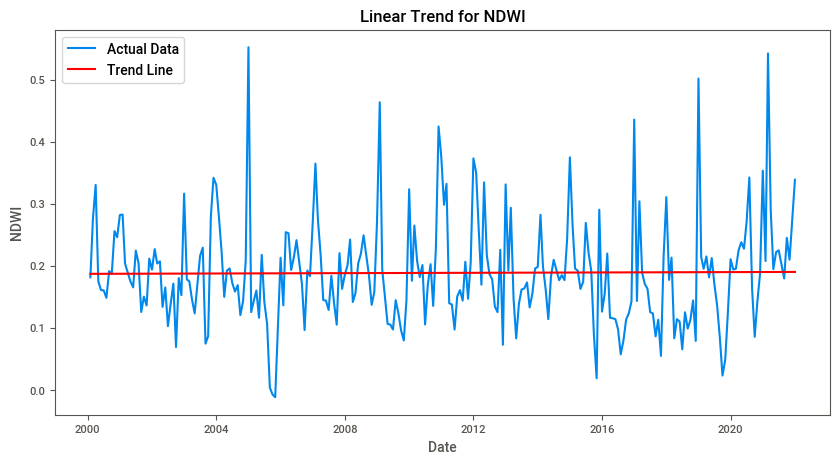

                            OLS Regression Results                            
Dep. Variable:                   NDWI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.02896
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.865
Time:                        13:11:01   Log-Likelihood:                 277.99
No. Observations:                 264   AIC:                            -552.0
Df Residuals:                     262   BIC:                            -544.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1870      0.010     17.975      0.0

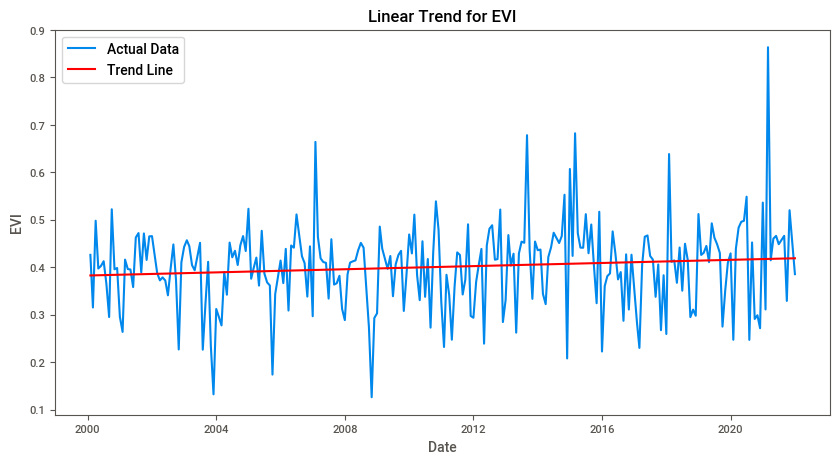

                            OLS Regression Results                            
Dep. Variable:                    EVI   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.730
Date:                Thu, 30 May 2024   Prob (F-statistic):             0.0545
Time:                        13:11:01   Log-Likelihood:                 267.50
No. Observations:                 264   AIC:                            -531.0
Df Residuals:                     262   BIC:                            -523.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3828      0.011     35.368      0.0

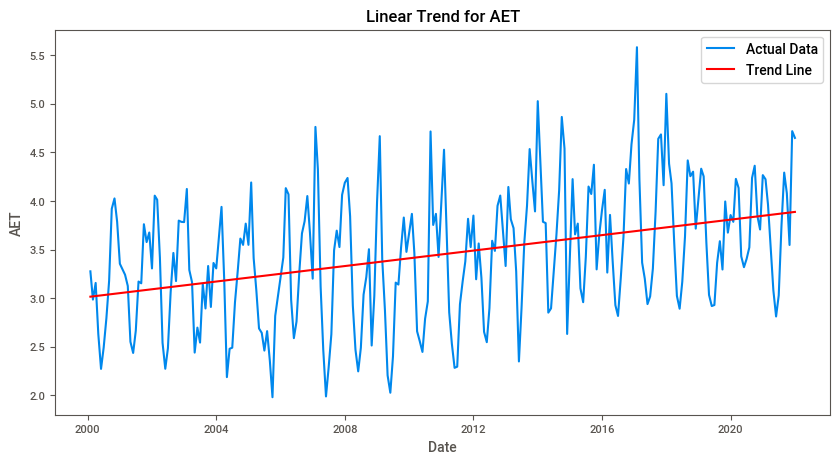

                            OLS Regression Results                            
Dep. Variable:                    AET   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     44.32
Date:                Thu, 30 May 2024   Prob (F-statistic):           1.63e-10
Time:                        13:11:02   Log-Likelihood:                -245.90
No. Observations:                 264   AIC:                             495.8
Df Residuals:                     262   BIC:                             502.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0156      0.076     39.851      0.0

In [116]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to apply linear regression and plot the trend
def plot_linear_regression(df, column):
    # Time as x variable, converted to numerical for regression purposes
    x = np.arange(len(df.index))
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    y = df[column]
    
    model = sm.OLS(y, x).fit()
    prediction = model.predict(x)
    
    # Plotting the data and the trend line
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, y, label='Actual Data')
    plt.plot(df.index, prediction, label='Trend Line', color='red')
    plt.title(f'Linear Trend for {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()
    
    return model.summary()

# Apply the function to each index and AET
for column in scaled_df.columns:
    summary = plot_linear_regression(combined_df, column)
    print(summary)


## Time Series Decomposition of Environmental Indices and AET

This section of the notebook illustrates how to decompose time series data into its constituent components: trend, seasonal, and residual. This method is particularly useful for understanding underlying patterns in time series data.

### Import Libraries
- **StatsModels**: Used for the `seasonal_decompose` function, which decomposes time series.
- **Matplotlib**: For plotting the decomposed components.

### Function for Time Series Decomposition
- **Function Definition**: `plot_decomposition` takes a DataFrame, a column name, and a period as inputs. The period typically corresponds to the frequency of the time series cycle (e.g., 12 for monthly data with annual patterns).
- **Decomposition Process**:
  - **Decompose**: Applies the `seasonal_decompose` method from StatsModels to the specified column in the DataFrame. The `model='additive'` assumes that the time series is a linear combination of its components.
- **Visualization**:
  - **Color and Style Setup**: Defines specific colors for each component to ensure clear visual distinction.
  - **Multiple Subplots**: Creates four subplots for trend, seasonal, residuals, and observed data.
  - **Plotting**: Each component of the decomposition (trend, seasonal, and residuals) and the original data are plotted in separate subplots.

### Plot Configuration
- **Execution**: Loops through each column in the `combined_df` DataFrame (which includes NDVI, NDWI, EVI, and AET) and applies the decomposition function, displaying the results for each.

### Utility
This decomposition allows analysts to visually identify and interpret trends, seasonality, and irregularities in environmental data, which can inform more effective monitoring and management strategies. By breaking down the series, one can better understand the dynamics influencing the observed changes over time.

### Conclusion
The output provides clear insights into the dynamics of each environmental parameter, aiding in the detection of patterns that might not be evident from the raw data alone. Such analysis is crucial for forecasting and planning purposes in environmental science.


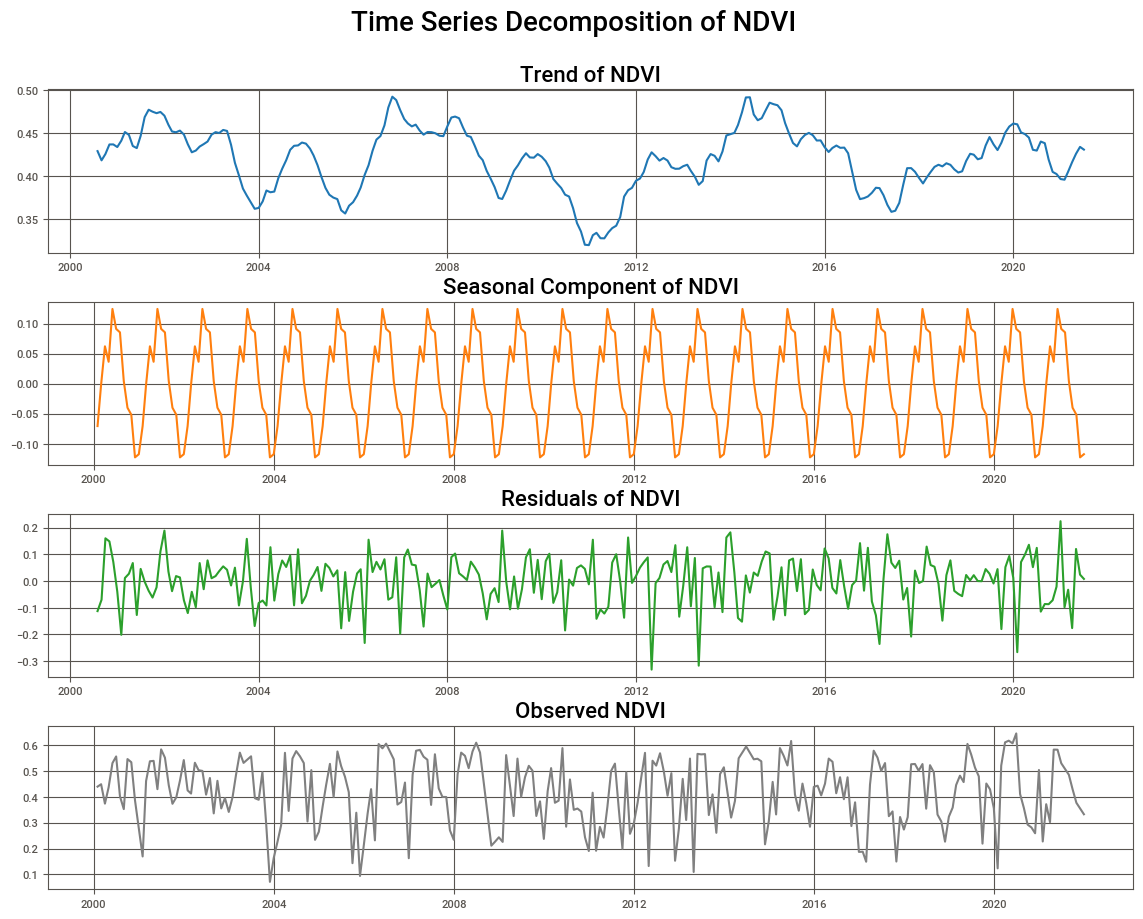

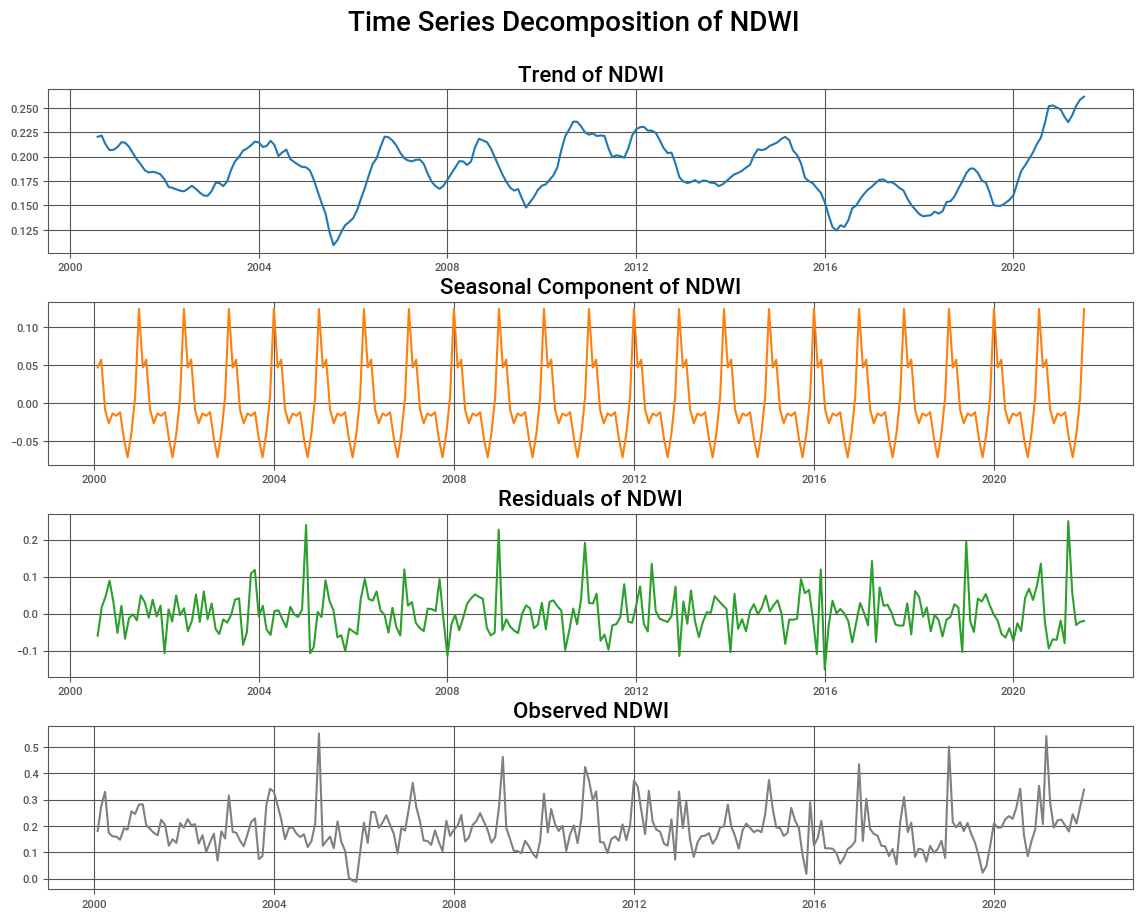

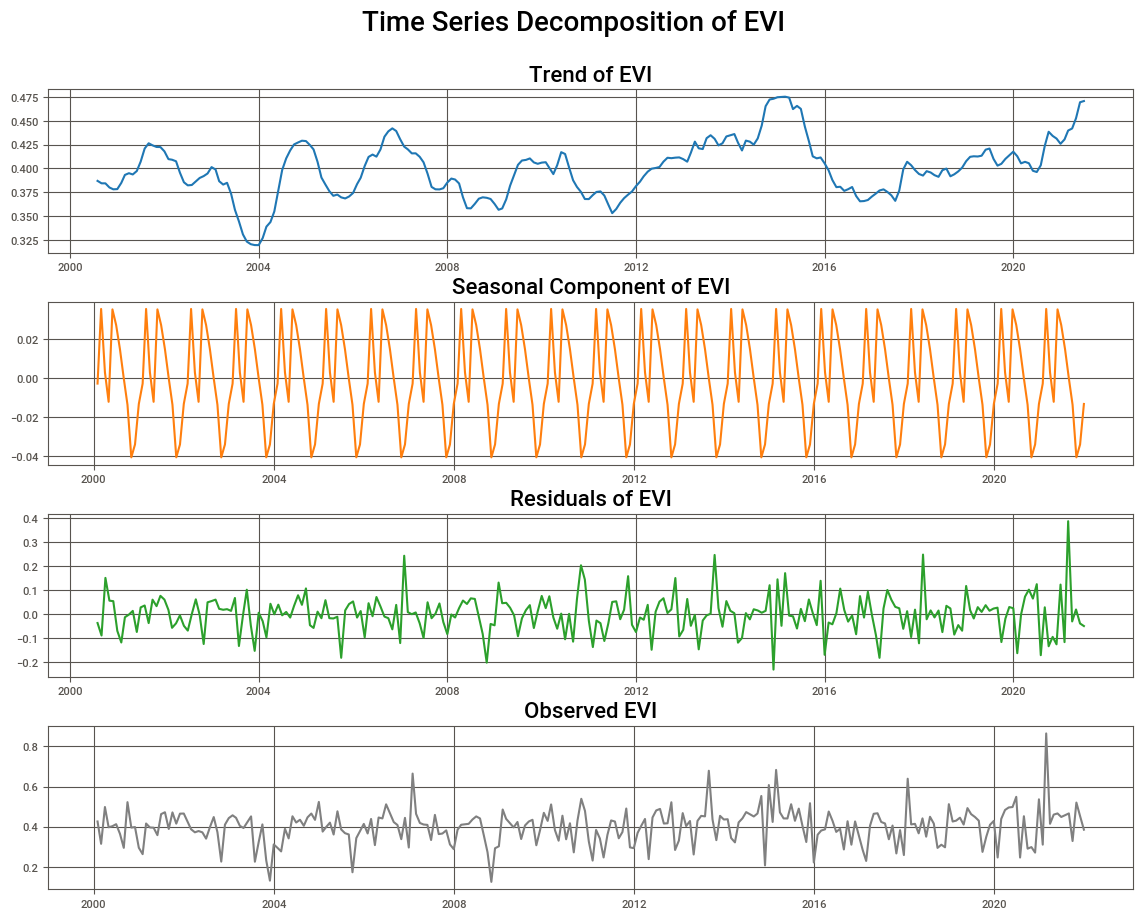

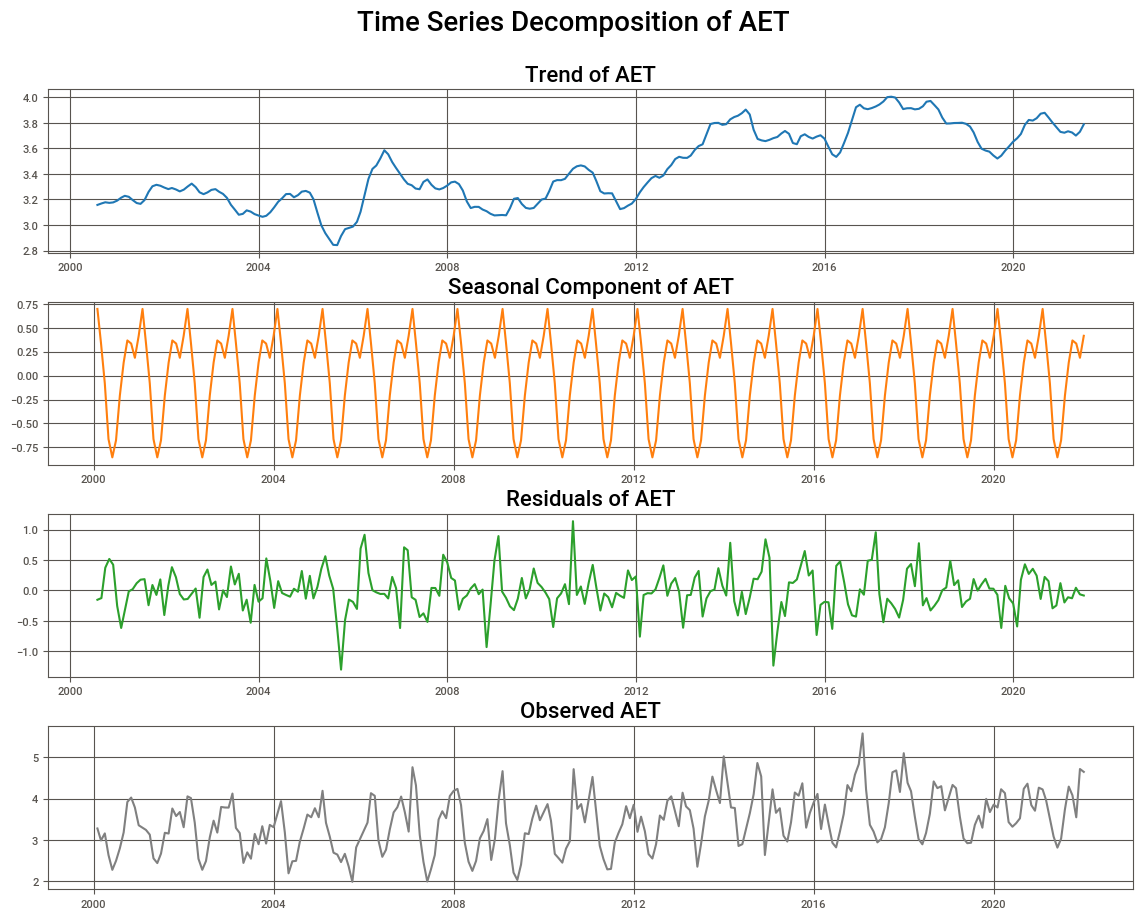

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def plot_decomposition(df, column, period=12):
    # Decompose the time series
    result = seasonal_decompose(df[column], model='additive', period=period)

    # Define colors and style
    trend_color = '#1f77b4'  # Blue color
    seasonal_color = '#ff7f0e'  # Orange color
    residual_color = '#2ca02c'  # Green color

    # Start plotting
    plt.figure(figsize=(14, 10))
    plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

    # Plot trend
    plt.subplot(411)
    plt.plot(result.trend, color=trend_color)
    plt.title(f'Trend of {column}', fontsize=16)
    plt.grid(True)

    # Plot seasonal
    plt.subplot(412)
    plt.plot(result.seasonal, color=seasonal_color)
    plt.title(f'Seasonal Component of {column}', fontsize=16)
    plt.grid(True)

    # Plot residuals
    plt.subplot(413)
    plt.plot(result.resid, color=residual_color)
    plt.title(f'Residuals of {column}', fontsize=16)
    plt.grid(True)

    # Plot observed
    plt.subplot(414)
    plt.plot(df[column], color='gray')
    plt.title(f'Observed {column}', fontsize=16)
    plt.grid(True)

    plt.suptitle(f'Time Series Decomposition of {column}', fontsize=20, y=0.98)
    plt.show()

# Apply the enhanced plotting function to each index and AET
for column in combined_df.columns:
    plot_decomposition(combined_df, column)


## Precipitation Data Analysis Using CHIRPS Dataset

This notebook section demonstrates how to process and visualize precipitation data from the CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data) dataset using Google Earth Engine, pandas, and Plotly.

### Initial Setup and Data Retrieval
- **Library Imports**: The script imports necessary libraries including `ee` for Google Earth Engine, `pandas` for data manipulation, `plotly.graph_objects` for visualization, and `pyperclip` for clipboard content handling.
- **Earth Engine Initialization**: Initializes the Google Earth Engine API which is essential for accessing the CHIRPS dataset.
- **Coordinate Retrieval**: Extracts latitude and longitude from the clipboard, which are then used to define the geographical point of interest.

### Data Collection
- **Time Range Definition**: Specifies the analysis period from January 1, 2000, to November 1, 2022.
- **Dataset Access**: Retrieves daily precipitation data from the CHIRPS dataset, filtering it by the specified time range and geographical bounds.

### Data Processing
- **Daily Precipitation Extraction**: A function (`get_daily_precip`) is defined to map over the CHIRPS image collection to extract daily precipitation values at the specified point.
- **DataFrame Conversion**: Converts the extracted data into a pandas DataFrame and filters out days with zero precipitation.
- **Date Coverage Completion**: Ensures the DataFrame covers all days in the specified range by reindexing with a complete date sequence.

### Data Analysis
- **Monthly Average Calculation**: Aggregates daily precipitation data into monthly averages to simplify analysis and visualization.

### Data Visualization
- **Plot Creation**: Uses Plotly to plot monthly average precipitation data. The plot is configured to display data points and trend lines, enhancing the visual representation.
- **Plot Customization**: Adjusts the plot layout with titles, axis labels, and a dark theme for better readability and interaction.

### Display and Output
- **Visualization Display**: Renders the interactive plot within the notebook, allowing for dynamic exploration of the data trends.
- **Data Preview**: Displays the head of the monthly averages DataFrame to provide a quick snapshot of the processed data.

### Conclusion
This script effectively demonstrates how to process, analyze, and visualize complex geospatial precipitation data using powerful tools like Google Earth Engine and Plotly. The approach is particularly useful for environmental researchers and climatologists interested in studying precipitation patterns over time.

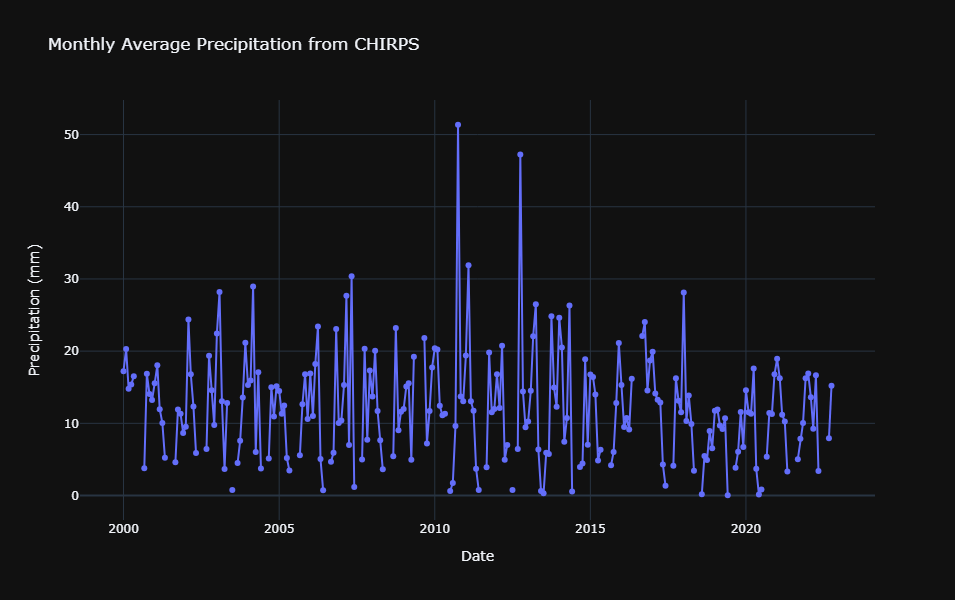

  year_month  daily_precip
0 2000-01-01     17.226869
1 2000-02-01     20.289852
2 2000-03-01     14.786825
3 2000-04-01     15.376303
4 2000-05-01     16.535986


In [118]:
import ee
import pandas as pd
import plotly.graph_objects as go
import pyperclip

# Initialize the Earth Engine API
ee.Initialize()

# Example clipboard content for dynamic inputs
clipboard_content = pyperclip.paste()
latitude_str, longitude_str = clipboard_content.strip().split(',')
latitude = float(latitude_str.strip())
longitude = float(longitude_str.strip())
point = ee.Geometry.Point([longitude, latitude])

# Define the time range for analysis
start_date = '2000-01-01'
end_date = '2022-11-01'

# Access the CHIRPS dataset for precipitation
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(start_date, end_date).filterBounds(point)

# Function to get daily precipitation
def get_daily_precip(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    daily_precip = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=point,
        scale=5000
    ).get('precipitation')
    return ee.Feature(None, {'date': date, 'daily_precip': daily_precip})

# Map the function over the collection
daily_precip = chirps.map(get_daily_precip).distinct('date')

# Convert to lists and get data for plotting
precip_list = daily_precip.aggregate_array('daily_precip').getInfo()
dates_precip = daily_precip.aggregate_array('date').getInfo()

# Convert to pandas DataFrame
df_precip = pd.DataFrame({'date': pd.to_datetime(dates_precip), 'daily_precip': precip_list})

# Remove rows with zero precipitation
df_precip = df_precip[df_precip['daily_precip'] > 0]

# Ensure full date coverage by creating a complete date range
all_days = pd.date_range(start=df_precip['date'].min(), end=df_precip['date'].max(), freq='D')
df_precip.set_index('date', inplace=True)
df_precip = df_precip.reindex(all_days)
df_precip.index.name = 'date'

# # Save raw data
# df_precip.to_csv('/mnt/data/CHIRPS_daily_precipitation_filtered.csv')

# Calculate monthly averages
df_precip['year_month'] = df_precip.index.to_period('M')
monthly_avg_precip = df_precip.groupby('year_month')['daily_precip'].mean().reset_index()
monthly_avg_precip['year_month'] = monthly_avg_precip['year_month'].dt.to_timestamp()

# Plotting the monthly average precipitation data
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_avg_precip['year_month'], y=monthly_avg_precip['daily_precip'], mode='lines+markers', name='Monthly Average Precipitation'))
fig.update_layout(
    title='Monthly Average Precipitation from CHIRPS',
    xaxis_title='Date',
    yaxis_title='Precipitation (mm)',
    legend_title='Parameter',
    template='plotly_dark',
    hovermode='x unified',
    width=1200,
    height=600
)
fig.show()

# Display raw data
print(monthly_avg_precip.head())


## Daily Temperature Analysis Using ERA5 Dataset

This Jupyter Notebook section details the process of fetching, processing, and visualizing daily temperature data from the ERA5 dataset using Google Earth Engine, pandas, and Plotly.

### Initial Setup and Data Retrieval
- **Library Imports**: The script utilizes `ee` for Google Earth Engine, `pandas` for handling data frames, `plotly.graph_objects` for creating interactive plots, and `pyperclip` for accessing clipboard content.
- **Earth Engine Initialization**: The Earth Engine API is initialized to facilitate access to environmental data sets.
- **Coordinate Retrieval**: Extracts latitude and longitude from the clipboard to define the specific geographical point for data extraction.

### Data Collection
- **Time Range Definition**: Specifies the period from January 1, 2000, to November 1, 2022, for the temperature analysis.
- **Dataset Access**: Accesses the ERA5 daily dataset, which includes meteorological data like mean 2-meter air temperature, filtered by date and geographic location.

### Data Processing
- **Temperature Extraction**: Implements a function `get_daily_temp` that retrieves the daily mean 2-meter air temperature for the specified location, converting it from Kelvin to Celsius.
- **Data Mapping**: Applies this function across the ERA5 image collection to compile daily temperature records.

### Data Transformation
- **DataFrame Creation**: Converts the list of daily temperatures and dates into a pandas DataFrame and handles any missing data by dropping rows without temperature values.
- **Date Range Completion**: Ensures the DataFrame covers all days in the analysis period by filling in missing dates and interpolating missing temperature values.

### Data Analysis
- **Monthly Averages**: Calculates the monthly average temperatures to simplify the data and focus on longer-term trends.


### Display and Output
- **Interactive Plot Display**: Showcases the interactive plot within the notebook, allowing users to explore temperature trends dynamically.
- **Data Preview**: Outputs the first few entries of the monthly average temperatures for a quick data review.

### Conclusion
This script demonstrates an efficient method for analyzing and visualizing time-series temperature data, aiding in the understanding of climate patterns and trends. It combines advanced data retrieval with practical visualization tools to provide meaningful insights into environmental data.


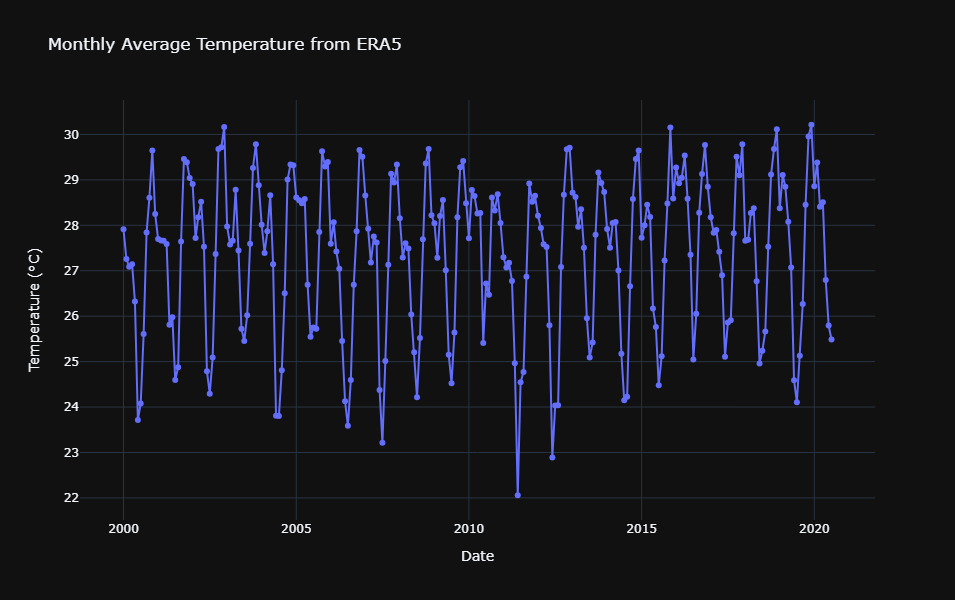

  year_month  daily_temp
0 2000-01-01   27.910464
1 2000-02-01   27.258140
2 2000-03-01   27.088445
3 2000-04-01   27.143350
4 2000-05-01   26.322027


In [119]:
import ee
import pandas as pd
import plotly.graph_objects as go
import pyperclip

# Initialize the Earth Engine API
ee.Initialize()

# Example clipboard content for dynamic inputs
clipboard_content = pyperclip.paste()
latitude_str, longitude_str = clipboard_content.strip().split(',')
latitude = float(latitude_str.strip())
longitude = float(longitude_str.strip())
point = ee.Geometry.Point([longitude, latitude])

# Define the time range for analysis
start_date = '2000-01-01'
end_date = '2022-11-01'

# Access the ERA5 dataset for daily temperature
era5 = ee.ImageCollection('ECMWF/ERA5/DAILY').filterDate(start_date, end_date).filterBounds(point)

# Function to get daily temperature
def get_daily_temp(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    daily_temp = image.select('mean_2m_air_temperature').subtract(273.15)  # Convert to Celsius
    mean_temp = daily_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('mean_2m_air_temperature')
    return ee.Feature(None, {'date': date, 'daily_temp': mean_temp})

# Map the function over the collection
daily_temp = era5.map(get_daily_temp).distinct('date')

# Convert to lists and get data for plotting
temp_list = daily_temp.aggregate_array('daily_temp').getInfo()
dates_temp = daily_temp.aggregate_array('date').getInfo()

# Convert to pandas DataFrame
df_temp = pd.DataFrame({'date': pd.to_datetime(dates_temp), 'daily_temp': temp_list})

# Remove rows with missing temperature data
df_temp = df_temp.dropna(subset=['daily_temp'])

# Ensure full date coverage by creating a complete date range
all_days = pd.date_range(start=df_temp['date'].min(), end=df_temp['date'].max(), freq='D')
df_temp.set_index('date', inplace=True)
df_temp = df_temp.reindex(all_days)
df_temp.index.name = 'date'

# Handle missing data by interpolation
df_temp.interpolate(inplace=True)

# Calculate the monthly average temperature
df_temp['year_month'] = df_temp.index.to_period('M')
monthly_avg_temp = df_temp.groupby('year_month')['daily_temp'].mean().reset_index()
monthly_avg_temp['year_month'] = monthly_avg_temp['year_month'].dt.to_timestamp()

# Plotting the monthly average temperature data
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_avg_temp['year_month'], y=monthly_avg_temp['daily_temp'], mode='lines+markers', name='Monthly Average Temperature'))
fig.update_layout(
    title='Monthly Average Temperature from ERA5',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    legend_title='Parameter',
    template='plotly_dark',
    hovermode='x unified',
    width=1200,
    height=600
)
fig.show()

# Display raw data
print(monthly_avg_temp.head())


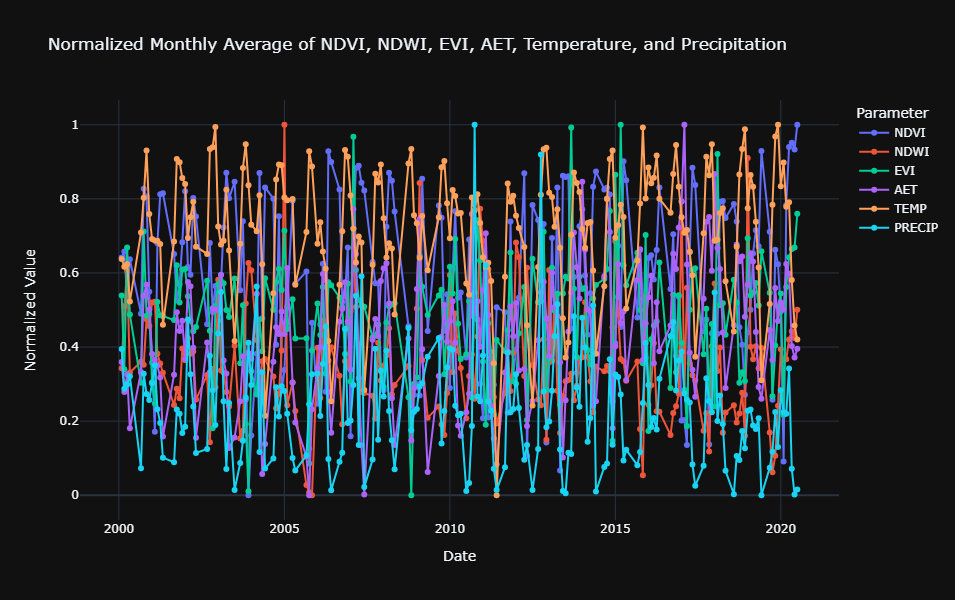

In [120]:
import ee
import pandas as pd
import plotly.graph_objects as go
import pyperclip

# Initialize the Earth Engine API
ee.Initialize()

# Example clipboard content for dynamic inputs
clipboard_content = pyperclip.paste()
latitude_str, longitude_str = clipboard_content.strip().split(',')
latitude = float(latitude_str.strip())
longitude = float(longitude_str.strip())
point = ee.Geometry.Point([longitude, latitude])

# Define the time range for analysis
start_date = '2000-01-01'
end_date = '2022-11-01'

# Access the ERA5 dataset for daily temperature
era5 = ee.ImageCollection('ECMWF/ERA5/DAILY').filterDate(start_date, end_date).filterBounds(point)

# Function to get daily temperature
def get_daily_temp(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    daily_temp = image.select('mean_2m_air_temperature').subtract(273.15)  # Convert to Celsius
    mean_temp = daily_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=1000
    ).get('mean_2m_air_temperature')
    return ee.Feature(None, {'date': date, 'daily_temp': mean_temp})

# Map the function over the collection
daily_temp = era5.map(get_daily_temp).distinct('date')

# Convert to lists and get data for plotting
temp_list = daily_temp.aggregate_array('daily_temp').getInfo()
dates_temp = daily_temp.aggregate_array('date').getInfo()

# Convert to pandas DataFrame
df_temp = pd.DataFrame({'date': pd.to_datetime(dates_temp), 'daily_temp': temp_list})

# Remove rows with missing temperature data
df_temp = df_temp.dropna(subset=['daily_temp'])

# Access the CHIRPS dataset for precipitation
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(start_date, end_date).filterBounds(point)

# Function to get daily precipitation
def get_daily_precip(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    daily_precip = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=point,
        scale=5000
    ).get('precipitation')
    return ee.Feature(None, {'date': date, 'daily_precip': daily_precip})

# Map the function over the collection
daily_precip = chirps.map(get_daily_precip).distinct('date')

# Convert to lists and get data for plotting
precip_list = daily_precip.aggregate_array('daily_precip').getInfo()
dates_precip = daily_precip.aggregate_array('date').getInfo()

# Convert to pandas DataFrame
df_precip = pd.DataFrame({'date': pd.to_datetime(dates_precip), 'daily_precip': precip_list})

# Remove rows with zero precipitation
df_precip = df_precip[df_precip['daily_precip'] > 0]

# Calculate monthly averages
df_temp['year_month'] = df_temp['date'].dt.to_period('M')
monthly_avg_temp = df_temp.groupby('year_month')['daily_temp'].mean().reset_index()
monthly_avg_temp['year_month'] = monthly_avg_temp['year_month'].dt.to_timestamp()

df_precip['year_month'] = df_precip['date'].dt.to_period('M')
monthly_avg_precip = df_precip.groupby('year_month')['daily_precip'].mean().reset_index()
monthly_avg_precip['year_month'] = monthly_avg_precip['year_month'].dt.to_timestamp()

# # Combine the monthly average temperature and precipitation data
# combined_df = pd.merge(monthly_avg_temp, monthly_avg_precip, on='year_month', how='outer')

# Load the Landsat 7 image collection and TERN AET dataset with applied filters
l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate(start_date, end_date).filterBounds(point)
aet_dataset = ee.ImageCollection('TERN/AET/CMRSET_LANDSAT_V2_2').filterDate(start_date, end_date).filterBounds(point)

def add_indices(image):
    """Function to calculate NDVI, NDWI, and EVI for Landsat 7 images."""
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
    ndwi = image.normalizedDifference(['B4', 'B5']).rename('NDWI')
    evi = image.expression('2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)', {'NIR': image.select('B4'), 'RED': image.select('B3'), 'BLUE': image.select('B1')}).rename('EVI')
    return image.addBands([ndvi, ndwi, evi])

def extract_values(image):
    """Extract index values from each Landsat image."""
    values = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=30)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'NDVI': values.get('NDVI'), 'NDWI': values.get('NDWI'), 'EVI': values.get('EVI')})

def extract_aet(image):
    """Extract AET values from each image in the TERN AET dataset."""
    aet_value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=point, scale=30).get('ETa')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'AET': aet_value})

# Process indices and AET
processed_l7 = l7.map(add_indices)
feature_collection = processed_l7.map(extract_values)
aet_collection = aet_dataset.map(extract_aet)

# # Convert to pandas DataFrame
# index_df = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])
# aet_df = pd.DataFrame([feat['properties'] for feat in aet_collection.getInfo()['features']])
# index_df['date'] = pd.to_datetime(index_df['date'])
# aet_df['date'] = pd.to_datetime(aet_df['date'])

# # Ensure full month coverage
# all_months = pd.period_range(start=index_df['date'].min(), end=aet_df['date'].max(), freq='M')
# index_df['year_month'] = index_df['date'].dt.to_period('M')
# aet_df['year_month'] = aet_df['date'].dt.to_period('M')

# # Monthly aggregation and sorting
# monthly_indices = index_df.groupby('year_month').agg({'NDVI': 'mean', 'NDWI': 'mean', 'EVI': 'mean'}).reindex(all_months)
# monthly_aet = aet_df.groupby('year_month').agg({'AET': 'mean'}).reindex(all_months)

# # Combine all data
# combined_df = pd.concat([monthly_indices, monthly_aet, monthly_avg_temp.set_index('year_month'), monthly_avg_precip.set_index('year_month')], axis=1)
# combined_df.index = combined_df.index.to_timestamp()

# # Apply Min-Max Scaling
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(combined_df)
# scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns, index=combined_df.index)

# # Plotting
# fig = go.Figure()
# for column in scaled_df.columns:
#     fig.add_trace(go.Scatter(x=scaled_df.index, y=scaled_df[column], mode='lines+markers', name=column))
# fig.update_layout(
#     title='Normalized Monthly Average of NDVI, NDWI, EVI, AET, Temperature, and Precipitation',
#     xaxis_title='Date',
#     yaxis_title='Normalized Value',
#     legend_title='Parameter',
#     template='plotly_dark',
#     hovermode='x unified',
#     width=1200,
#     height=600
# )
# fig.show()

# # Display raw data
# print(combined_df.head())


# Convert to pandas DataFrame
index_df = pd.DataFrame([feat['properties'] for feat in feature_collection.getInfo()['features']])
aet_df = pd.DataFrame([feat['properties'] for feat in aet_collection.getInfo()['features']])
index_df['date'] = pd.to_datetime(index_df['date'])
aet_df['date'] = pd.to_datetime(aet_df['date'])

# # Ensure full month coverage
# all_months = pd.period_range(start=index_df['date'].min(), end=aet_df['date'].max(), freq='M')
# index_df['year_month'] = index_df['date'].dt.to_period('M')
# aet_df['year_month'] = aet_df['date'].dt.to_period('M')

# # Monthly aggregation and sorting
# monthly_indices = index_df.groupby('year_month').agg({'NDVI': 'mean', 'NDWI': 'mean', 'EVI': 'mean'}).reindex(all_months)
# monthly_aet = aet_df.groupby('year_month').agg({'AET': 'mean'}).reindex(all_months)

# # Combine all data
# combined_df = pd.concat([monthly_indices, monthly_aet, monthly_avg_temp.set_index('year_month'), monthly_avg_precip.set_index('year_month')], axis=1)
# combined_df.index = combined_df.index.to_timestamp()

# # Apply Min-Max Scaling
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(combined_df)
# scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns, index=combined_df.index)

# # Plotting
# fig = go.Figure()
# for column in scaled_df.columns:
#     fig.add_trace(go.Scatter(x=scaled_df.index, y=scaled_df[column], mode='lines+markers', name=column))
# fig.update_layout(
#     title='Normalized Monthly Average of NDVI, NDWI, EVI, AET, Temperature, and Precipitation',
#     xaxis_title='Date',
#     yaxis_title='Normalized Value',
#     legend_title='Parameter',
#     template='plotly_dark',
#     hovermode='x unified',
#     width=1200,
#     height=600
# )
# fig.show()

# # Display raw data
# print(combined_df.head())


# Ensure full month coverage
all_months = pd.period_range(start=index_df['date'].min(), end=aet_df['date'].max(), freq='M')
index_df['year_month'] = index_df['date'].dt.to_period('M')
aet_df['year_month'] = aet_df['date'].dt.to_period('M')



# # Monthly aggregation and sorting
# monthly_indices = index_df.groupby('year_month').agg({'NDVI': 'mean', 'NDWI': 'mean', 'EVI': 'mean'}).reindex(all_months)
# monthly_aet = aet_df.groupby('year_month').agg({'AET': 'mean'}).reindex(all_months)

# Monthly aggregation and sorting
monthly_indices = index_df.groupby('year_month').agg({'NDVI': 'mean', 'NDWI': 'mean', 'EVI': 'mean'}).reindex(all_months).reset_index()
monthly_aet = aet_df.groupby('year_month').agg({'AET': 'mean'}).reindex(all_months).reset_index()
# Rename index to year_month in monthly_aet
monthly_aet.rename(columns={'index': 'year_month'}, inplace=True)
# Rename index to year_month in monthly_aet
monthly_indices.rename(columns={'index': 'year_month'}, inplace=True)



# Convert year_month to datetime for consistent merging
monthly_indices['year_month'] = pd.to_datetime(monthly_indices['year_month'].astype(str))
monthly_aet['year_month'] = pd.to_datetime(monthly_aet['year_month'].astype(str))
monthly_avg_temp['year_month'] = pd.to_datetime(monthly_avg_temp['year_month'].astype(str))
monthly_avg_precip['year_month'] = pd.to_datetime(monthly_avg_precip['year_month'].astype(str))


# # Combine all data
# combined_df = pd.concat([monthly_indices.set_index('year_month'), 
#                          monthly_aet.set_index('year_month'), 
#                          monthly_avg_temp.set_index('year_month'), 
#                          monthly_avg_precip.set_index('year_month')], axis=1).reset_index()

# Combine all data
combined_df = pd.concat([monthly_indices.set_index('year_month'), 
                         monthly_aet.set_index('year_month'), 
                         monthly_avg_temp.set_index('year_month').rename(columns={'daily_temp': 'TEMP'}), 
                         monthly_avg_precip.set_index('year_month').rename(columns={'daily_precip': 'PRECIP'})], axis=1).reset_index()

# Remove rows with null values
combined_df.dropna(inplace=True)

# Apply Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df.drop(columns='year_month'))
scaled_df = pd.DataFrame(scaled_data, columns=combined_df.columns[1:], index=combined_df['year_month'])


# Plotting
fig = go.Figure()
for column in scaled_df.columns:
    fig.add_trace(go.Scatter(x=scaled_df.index, y=scaled_df[column], mode='lines+markers', name=column))
fig.update_layout(
    title='Normalized Monthly Average of NDVI, NDWI, EVI, AET, Temperature, and Precipitation',
    xaxis_title='Date',
    yaxis_title='Normalized Value',
    legend_title='Parameter',
    template='plotly_dark',
    hovermode='x unified',
    width=1200,
    height=600
)
fig.show()




In [121]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2000-02-01 to 2020-07-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    195 non-null    float64
 1   NDWI    195 non-null    float64
 2   EVI     195 non-null    float64
 3   AET     195 non-null    float64
 4   TEMP    195 non-null    float64
 5   PRECIP  195 non-null    float64
dtypes: float64(6)
memory usage: 10.7 KB


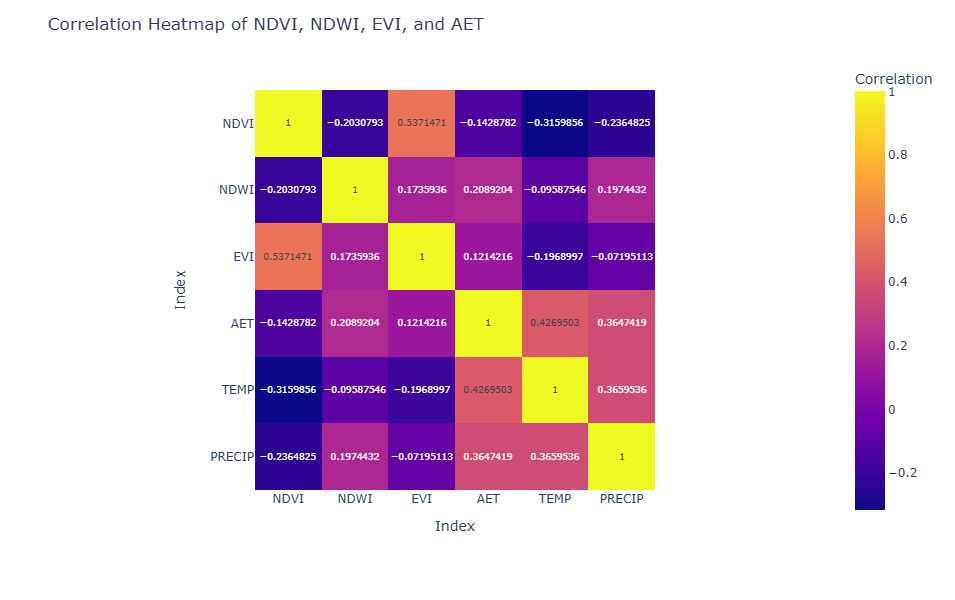

In [122]:
import plotly.express as px

# Assuming 'combined_df' is your DataFrame from previous processing steps

# Calculate the correlation matrix
corr_matrix = scaled_df.corr()

# Create a heatmap
fig_heatmap = px.imshow(corr_matrix, text_auto=True,
                        labels=dict(x="Index", y="Index", color="Correlation"),
                        x=corr_matrix.columns,
                        y=corr_matrix.columns)
fig_heatmap.update_layout(title="Correlation Heatmap of NDVI, NDWI, EVI, and AET",
                          width=600, height=600)
fig_heatmap.show()


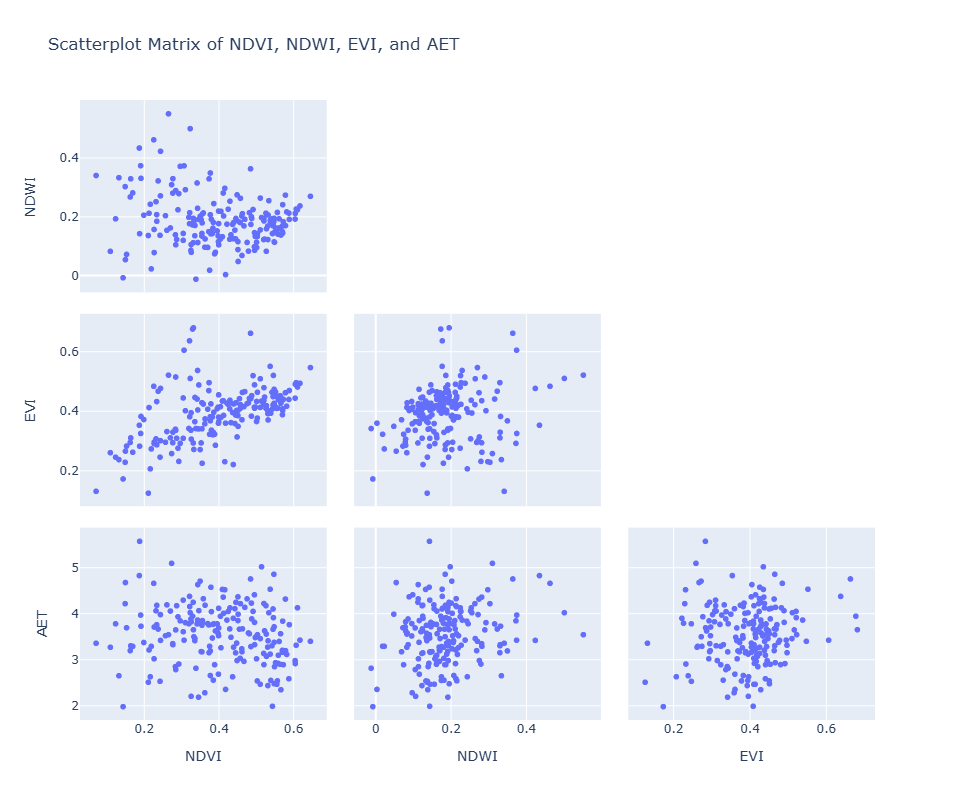

In [123]:
# Create a scatterplot matrix
fig_scatter_matrix = px.scatter_matrix(combined_df,
                                       dimensions=['NDVI', 'NDWI', 'EVI', 'AET'],
                                       labels={col: col for col in scaled_df.columns},
                                       title="Scatterplot Matrix of NDVI, NDWI, EVI, and AET")
fig_scatter_matrix.update_traces(diagonal_visible=False, showupperhalf=False)  # Remove duplicates
fig_scatter_matrix.update_layout(width=800, height=800)
fig_scatter_matrix.show()


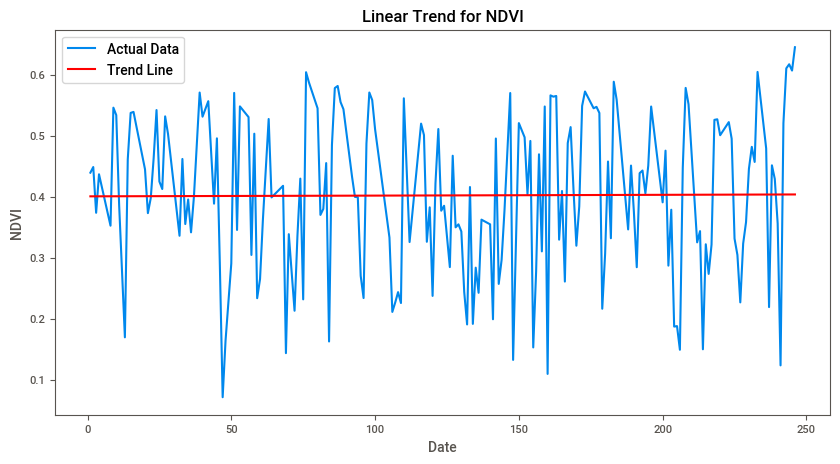

                            OLS Regression Results                            
Dep. Variable:                   NDVI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.009251
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.923
Time:                        13:13:44   Log-Likelihood:                 122.65
No. Observations:                 195   AIC:                            -241.3
Df Residuals:                     193   BIC:                            -234.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4007      0.019     21.661      0.0

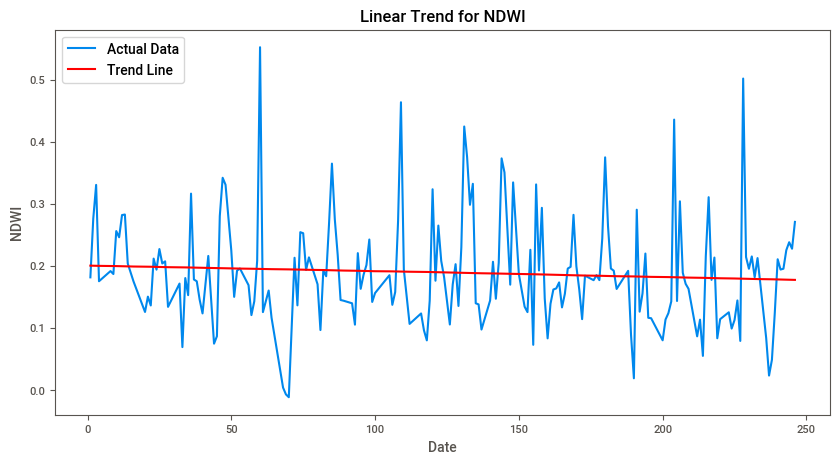

                            OLS Regression Results                            
Dep. Variable:                   NDWI   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.127
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.290
Time:                        13:13:44   Log-Likelihood:                 199.23
No. Observations:                 195   AIC:                            -394.5
Df Residuals:                     193   BIC:                            -387.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2002      0.012     16.023      0.0

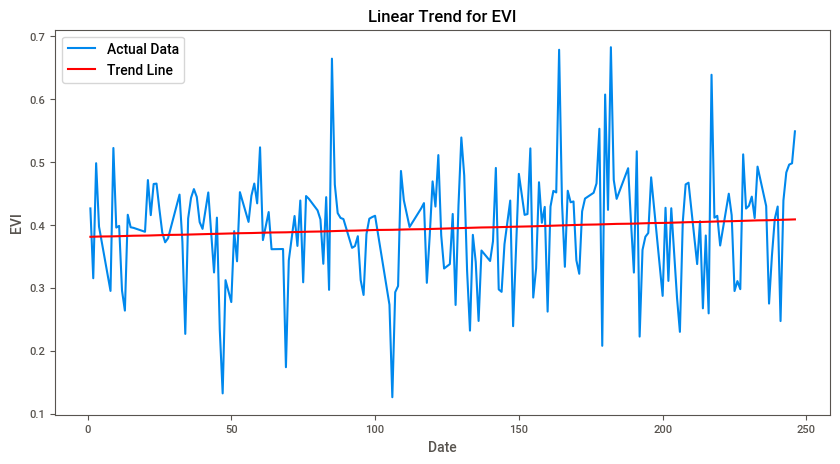

                            OLS Regression Results                            
Dep. Variable:                    EVI   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.568
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.212
Time:                        13:13:44   Log-Likelihood:                 194.97
No. Observations:                 195   AIC:                            -385.9
Df Residuals:                     193   BIC:                            -379.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3811      0.013     29.850      0.0

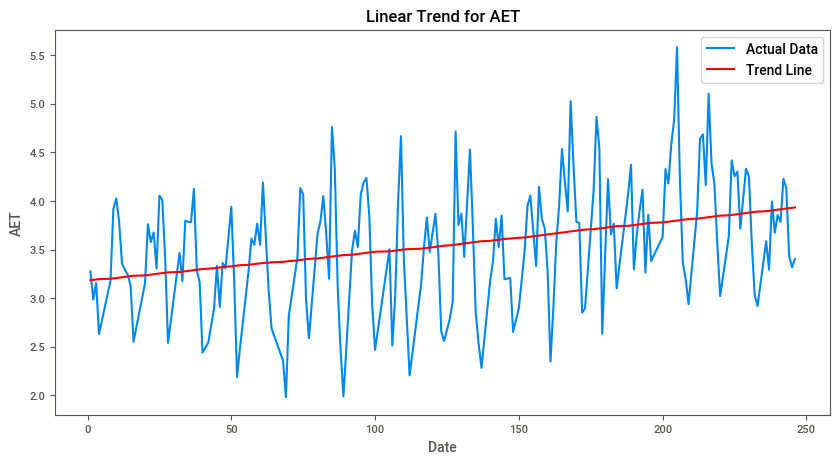

                            OLS Regression Results                            
Dep. Variable:                    AET   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     25.04
Date:                Thu, 30 May 2024   Prob (F-statistic):           1.26e-06
Time:                        13:13:44   Log-Likelihood:                -178.16
No. Observations:                 195   AIC:                             360.3
Df Residuals:                     193   BIC:                             366.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1844      0.087     36.804      0.0

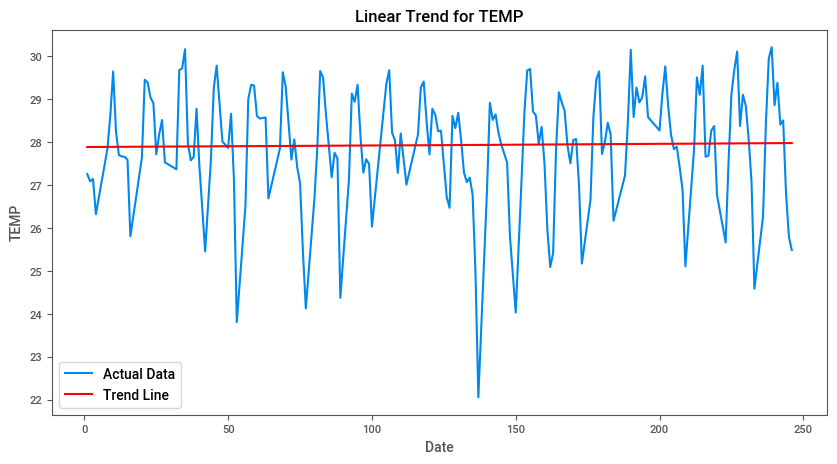

                            OLS Regression Results                            
Dep. Variable:                   TEMP   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.07435
Date:                Thu, 30 May 2024   Prob (F-statistic):              0.785
Time:                        13:13:44   Log-Likelihood:                -336.54
No. Observations:                 195   AIC:                             677.1
Df Residuals:                     193   BIC:                             683.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.8884      0.195    143.072      0.0

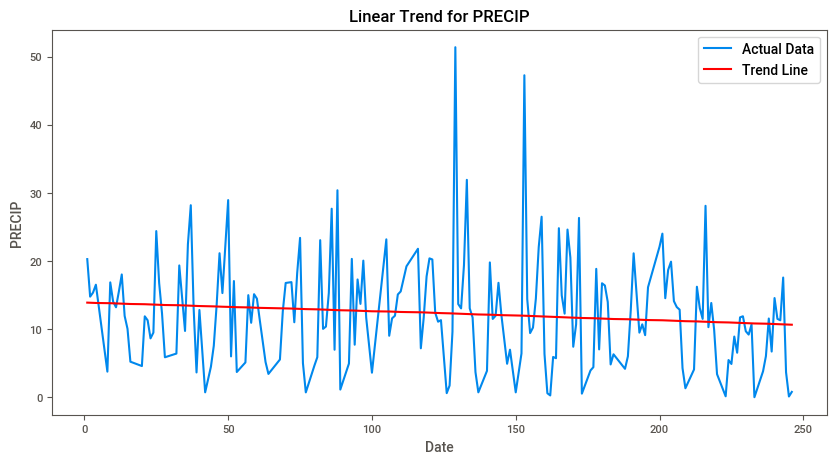

                            OLS Regression Results                            
Dep. Variable:                 PRECIP   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.760
Date:                Thu, 30 May 2024   Prob (F-statistic):             0.0983
Time:                        13:13:45   Log-Likelihood:                -678.74
No. Observations:                 195   AIC:                             1361.
Df Residuals:                     193   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9088      1.127     12.339      0.0

In [124]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to apply linear regression and plot the trend
def plot_linear_regression(df, column):
    # Time as x variable, converted to numerical for regression purposes
    x = np.arange(len(df.index))
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    y = df[column]
    
    model = sm.OLS(y, x).fit()
    prediction = model.predict(x)
    
    # Plotting the data and the trend line
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, y, label='Actual Data')
    plt.plot(df.index, prediction, label='Trend Line', color='red')
    plt.title(f'Linear Trend for {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()
    
    return model.summary()

# Apply the function to each index and AET
for column in scaled_df.columns:
    summary = plot_linear_regression(combined_df, column)
    print(summary)


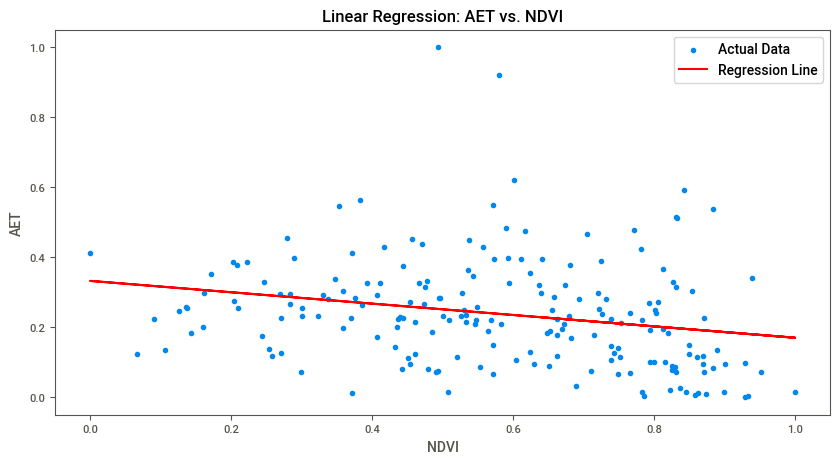

                            OLS Regression Results                            
Dep. Variable:                 PRECIP   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     11.43
Date:                Thu, 30 May 2024   Prob (F-statistic):           0.000873
Time:                        13:13:45   Log-Likelihood:                 93.439
No. Observations:                 195   AIC:                            -182.9
Df Residuals:                     193   BIC:                            -176.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3323      0.030     11.184      0.0

In [125]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and is already loaded with data
# df = pd.read_csv('your_data.csv')  # Load data if not already done

df = scaled_df

# Extract the necessary columns
x = df['NDVI']  # Independent variable
y = df['PRECIP']   # Dependent variable

# Add a constant to the model (the intercept)
x_with_const = sm.add_constant(x)

# Fit the linear regression model
model = sm.OLS(y, x_with_const).fit()

# Get the predicted values
predictions = model.predict(x_with_const)

# Plot the data and the regression line
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Actual Data')
plt.plot(x, predictions, color='red', label='Regression Line')
plt.title('Linear Regression: AET vs. NDVI')
plt.xlabel('NDVI')
plt.ylabel('AET')
plt.legend()
plt.show()

# Print the summary of the regression results
print(model.summary())


## Multiple Linear Regression Analysis for Predicting AET

This section demonstrates how to conduct a multiple linear regression analysis to predict Actual Evapotranspiration (AET) using a set of environmental predictors. The script utilizes pandas for data handling, Statsmodels for regression analysis, and Matplotlib for visualization.

### Import Libraries
- **Pandas and NumPy**: Used for data manipulation and numerical operations.
- **Statsmodels**: Provides tools for the estimation of many different statistical models, as well as for conducting statistical tests and exploring data.
- **Matplotlib**: Used to create figures and plots for visual representation of data.

### Data Preparation
- **Independent Variables (Predictors)**: Prepares a set of predictors (NDVI, NDWI, EVI, temperature, and precipitation) and includes a constant term to account for the intercept in the linear model.
- **Dependent Variable (Response)**: Sets AET as the target variable for prediction.

### Model Fitting
- **Linear Regression Model**: Fits a linear regression model using the ordinary least squares (OLS) method from Statsmodels to the prepared data.
- **Model Summary**: Prints a detailed summary of the regression results, which includes coefficients, standard errors, p-values, R-squared value, and other statistical measures.

### Prediction and Visualization
- **Prediction**: Computes the predicted AET values based on the fitted model.
- **Plotting Results**:
  - **Actual vs. Predicted AET**: Plots both actual and predicted AET values over time (or other indices, depending on the DataFrame) to visualize the accuracy and performance of the model.
  - **Plot Configuration**: Configures the plot with appropriate labels, title, and legend to enhance readability and interpretation.

### Conclusion
This analysis provides insights into how well the selected environmental indices can predict AET, aiding in water resource management and planning. The visual comparison between actual and predicted values serves as a straightforward metric for assessing model performance.




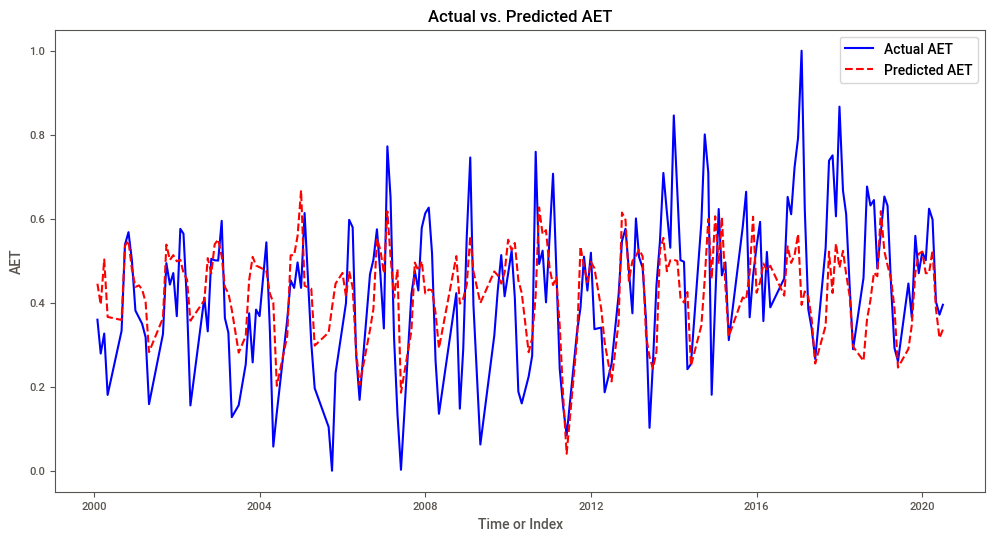

                            OLS Regression Results                            
Dep. Variable:                    AET   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     16.72
Date:                Thu, 30 May 2024   Prob (F-statistic):           1.15e-13
Time:                        13:13:45   Log-Likelihood:                 95.412
No. Observations:                 195   AIC:                            -178.8
Df Residuals:                     189   BIC:                            -159.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0764      0.078     -0.975      0.3

In [126]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and is already loaded with data

# Prepare the independent variables (add a constant for the intercept)
X = df[['NDVI', 'NDWI', 'EVI', 'TEMP', 'PRECIP']]  # Include other predictors as needed
X = sm.add_constant(X)  # Adds a constant term to the predictor variables

# Prepare the dependent variable
Y = df['AET']

# Fit the multiple linear regression model
model = sm.OLS(Y, X).fit()

# Get the predicted AET values
predictions = model.predict(X)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, Y, label='Actual AET', linestyle='-', marker='', color='blue')
plt.plot(df.index, predictions, label='Predicted AET', linestyle='--', marker='', color='red')
plt.title('Actual vs. Predicted AET')
plt.xlabel('Time or Index')  # Adjust as per your DataFrame index
plt.ylabel('AET')
plt.legend()
plt.show()

# Print the summary of the regression results
print(model.summary())


## Feature Selection for Predicting AET Using Lasso and Backward Elimination

This section of the notebook demonstrates the use of Lasso regression for feature regularization and selection, followed by backward elimination to refine the model further. The analysis aims to identify the most significant predictors of Actual Evapotranspiration (AET) from a set of environmental indices.

### Import Libraries
- **Statsmodels**: Used for fitting ordinary least squares (OLS) regression models and performing backward elimination.
- **Sklearn**: Implements Lasso regression with cross-validation and standard scaling of features.

### Data Preparation
- **Feature Scaling**: Normalizes the feature set comprising NDVI, NDWI, EVI, temperature (TEMP), and precipitation (PRECIP) to ensure that the Lasso model treats all variables equally.
- **Dependent Variable**: Sets AET as the response variable for the regression models.

### Lasso Regression
- **Model Fitting**: Fits a Lasso model with cross-validation (5 folds) to determine the optimal regularization parameter that minimizes prediction error, thus enhancing model accuracy.
- **Output Coefficients**: Prints the coefficients from the Lasso model to identify which features are most influential in predicting AET. Features with coefficients reduced to zero are deemed less important by the model.

### Backward Elimination
- **Initial Model**: Fits an initial OLS model using all features.
- **Elimination Process**:
  - **Iterative Removal**: Performs backward elimination by iteratively removing the feature with the highest p-value (above the significance level of 0.05) until all remaining features are statistically significant.
  - **Model Refitting**: Refits the OLS model after each feature removal to update the model's parameters based on the reduced feature set.
- **Final Model Summary**: Prints a summary of the refined OLS model, providing detailed statistics including coefficients, standard errors, p-values, and model diagnostics.

### Conclusion
The combined approach of Lasso for regularization and backward elimination for model simplification allows for a clear interpretation of the data, highlighting the features that have a significant impact on AET. This methodology helps in building a parsimonious model, ensuring that only the most relevant predictors are included, thereby improving the model’s interpretability and performance.




In [127]:
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and is already loaded with data

# Scale features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['NDVI', 'NDWI', 'EVI', 'TEMP', 'PRECIP']])
Y = df['AET']

# Fit Lasso model with cross-validation
lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, Y)
print("Lasso Coefficients:", lasso.coef_)

# Backward Elimination
X = df[['NDVI', 'NDWI', 'EVI', 'TEMP', 'PRECIP']]
X = sm.add_constant(X)  # Adding a constant
model = sm.OLS(Y, X).fit()
while max(model.pvalues) > 0.05:
    X = X.drop(model.pvalues.idxmax(), axis=1)
    model = sm.OLS(Y, X).fit()

print("Final model summary using Backward Elimination:")
print(model.summary())


Lasso Coefficients: [-0.          0.02704249  0.02656664  0.06664039  0.03141391]
Final model summary using Backward Elimination:
                                 OLS Regression Results                                
Dep. Variable:                    AET   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              431.0
Date:                Thu, 30 May 2024   Prob (F-statistic):                    2.16e-94
Time:                        13:13:45   Log-Likelihood:                          94.018
No. Observations:                 195   AIC:                                     -180.0
Df Residuals:                     191   BIC:                                     -166.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                         

In [92]:
# # Import libraries
# import pandas as pd
# import sweetviz as sv

# # Produce and save the profiling report
# report = sv.analyze(scaled_df)
# # report.show_html('report.html')

In [93]:
# # Import libraries
# import pandas as pd
# import sweetviz as sv

# df = pd.read_csv('Vegetation Sites.csv')

# # Produce and save the profiling report
# report = sv.analyze(df)
# report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [94]:
# import pandas as pd

# # Load the vegetation sites data
# df_vegetation = pd.read_csv('Vegetation Sites.csv')

# # Define a list of potential GDE trees based on ecological knowledge
# gde_trees = ['Eucalyptus camaldulensis', 'Melaleuca viridiflora', 'Acacia aneura', 
#              'Eucalyptus tetrodonta', 'Corymbia terminalis']

# # Filter the dataframe for GDE trees
# df_gde = df_vegetation[df_vegetation['Upper Stratum'].str.contains('|'.join(gde_trees), na=False)]

# # Load environmental data assuming it's stored in another CSV
# df_env = scaled_df


In [95]:
# import pandas as pd
# import numpy as np

# # Assuming environmental and vegetation data are loaded as described previously

# # Assuming df_vegetation is your vegetation DataFrame
# # Ensure 'Upper Stratum' and 'Site date' matches your actual column names
# df_vegetation['Site date'] = pd.to_datetime(df_vegetation['Site date'])

# # Filter for GDE trees, replace 'Upper Stratum' with your column name if different
# gde_trees = ['Eucalyptus camaldulensis', 'Melaleuca viridiflora', 'Acacia aneura', 
#              'Eucalyptus tetrodonta', 'Corymbia terminalis']
# df_gde = df_vegetation[df_vegetation['Upper Stratum'].str.contains('|'.join(gde_trees), na=False)]

# # Assuming df_env is your environmental DataFrame
# # The column names here ('NDVI', 'AET', 'PRECIP', 'TEMP') should match exactly what's in your CSV
# df_env['Date'] = pd.to_datetime(df_env['Date'])
# df_merged = pd.merge(df_gde, df_env, left_on='Site date', right_on='Date', how='inner')

# # Correlation analysis
# columns_to_correlate = ['NDVI', 'AET', 'PRECIP', 'TEMP']
# df_correlation = df_merged[columns_to_correlate]
# correlation_matrix = df_correlation.corr()

# # Print the correlation matrix
# print(correlation_matrix)


KeyError: 'Date'

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'scaled_df' is already loaded as shown

# # Calculate the correlation matrix
# correlation_matrix = scaled_df.corr()

# # Print the correlation matrix
# print(correlation_matrix)

# # Plot a heatmap for visual representation of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Environmental Variables')
# plt.show()


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Choose a variable to decompose, for example, AET
# result = seasonal_decompose(scaled_df['AET'], model='additive', period=12)  # period depends on data frequency

# # Plot the decomposed components
# result.plot()
# plt.show()


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # Define the independent variables and the target variable
# X = scaled_df[['NDVI', 'NDWI', 'EVI', 'TEMP', 'PRECIP']]
# y = scaled_df['AET']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Calculate the mean squared error of the model
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)


In [75]:
# import pandas as pd

# # Load the DataFrame
# df_vegetation = pd.read_csv('Vegetation Sites.csv')

# # Define GDE trees species list
# gde_trees = ['Eucalyptus camaldulensis', 'Melaleuca viridiflora', 'Acacia aneura', 
#              'Eucalyptus tetrodonta', 'Corymbia terminalis']

# # Create a filtered copy of the DataFrame
# df_gde = df_vegetation[df_vegetation['Upper Stratum'].str.contains('|'.join(gde_trees), na=True, case=False)].copy()

# # Function to categorize vegetation
# def categorize_vegetation(row):
#     if pd.isna(row['Upper Stratum']):
#         return 'Unknown'
#     if 'Eucalyptus' in row['Upper Stratum']:
#         return 'Eucalyptus Dominated'
#     elif 'Acacia' in row['Upper Stratum']:
#         return 'Acacia Dominated'
#     elif 'Melaleuca' in row['Upper Stratum']:
#         return 'Melaleuca Dominated'
#     else:
#         return 'Other'

# # Safely applying the function to create a new column
# df_gde['Vegetation Category'] = df_gde.apply(categorize_vegetation, axis=1)

# # Print to verify and check
# print(df_gde)

# # Save or proceed with further operations
# df_gde.to_csv('GDE_Tree_Locations_and_Categories.csv', index=False)


       Unique ID                                        Survey name  \
0           3640                                     Daly Catchment   
2           3639                  Barkly District Land Unit Surveys   
3           3630  The Pastoral Land Resources of Murray Downs St...   
5           3632  The Pastoral Land Resources of Murray Downs St...   
8           3635            The Land Resources of Lyndavale Station   
...          ...                                                ...   
86294      51877                         Threatened Species Surveys   
86296      75829                                       ARIDWETLANDS   
86297       3627  The Pastoral Land Resources of Murray Downs St...   
86298      51879                         Threatened Species Surveys   
86299      75828                                       ARIDWETLANDS   

              Survey code         Site code                    Survey site  \
0                   ELIZD               156                      ELIZ

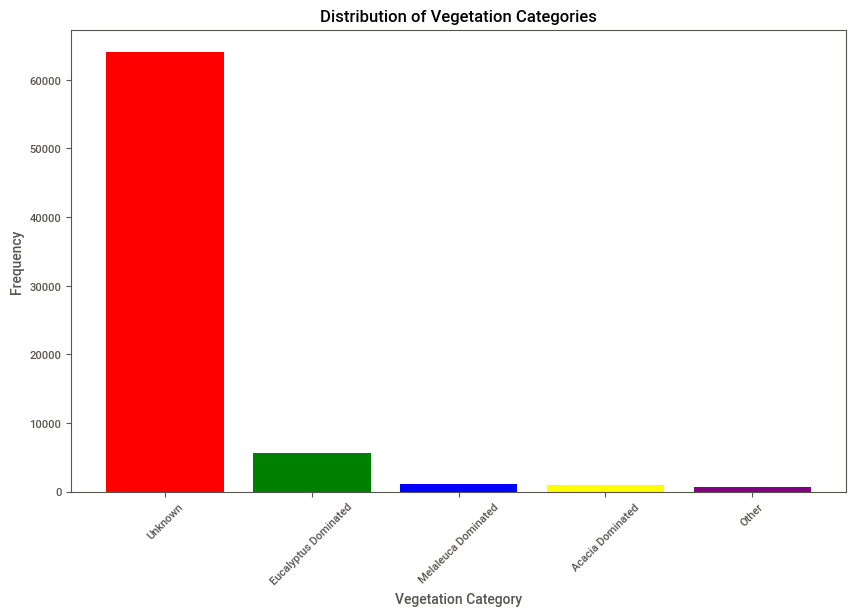

In [71]:
# import matplotlib.pyplot as plt

# # Count the frequency of each category
# category_counts = df_gde['Vegetation Category'].value_counts()
# colors = ['red', 'green', 'blue', 'yellow', 'purple']  # More colors can be added as needed

# plt.figure(figsize=(10, 6))
# plt.bar(category_counts.index, category_counts.values, color=colors)
# plt.title('Distribution of Vegetation Categories')
# plt.xlabel('Vegetation Category')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()


C:\Users\mathe\AppData\Local\Temp\ipykernel_7708\1436143481.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



<Figure size 1000x600 with 0 Axes>

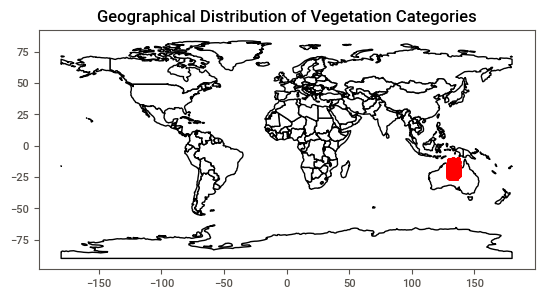

In [73]:
# import geopandas as gpd
# from shapely.geometry import Point

# # Convert DataFrame to GeoDataFrame
# gdf = gpd.GeoDataFrame(df_gde, geometry=gpd.points_from_xy(df_gde.Longitude, df_gde.Latitude))

# # Plotting
# plt.figure(figsize=(10, 6))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# base = world.plot(color='white', edgecolor='black')
# gdf.plot(ax=base, marker='o', color='red', markersize=5)
# plt.title('Geographical Distribution of Vegetation Categories')
# plt.show()
